# 6.6 Sourcing & Analyzing Time-Series Data

### This script contains the following:

#### 1. Importing your libraries and data
#### 2. Subsetting, wrangling, and cleaning time-series data
#### 3. Time series analysis: decomposition
#### 4. Testing for stationarity
#### 5. Stationarizing the Federal Reserve Economic Data

### 1. Importing your libraries and data

Before you start this analysis, you'll need a new library you haven't installed before—Quandl. Install Quandl using conda:

`conda install quandl`

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore")
# Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight')
# This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [2]:
# Configure API key 

quandl.ApiConfig.api_key = 'wLwtNM_zNq2jk3Gahxje'

### Import dataset : US Federal Reserve GDP dataset

In [3]:
# Importing the Federal Reserve Economic Data "Natural Rate of Unemployment" variable.

data = quandl.get('FRED/GDP')

In [4]:
data.head(5)

,Value
Date,
1947-01-01,243.164
1947-04-01,245.968
1947-07-01,249.585
1947-10-01,259.745
1948-01-01,265.742


In [5]:
data.shape

(300, 1)

In [6]:
data.columns

Index(['Value'], dtype='object')

In [7]:
type(data)

pandas.core.frame.DataFrame

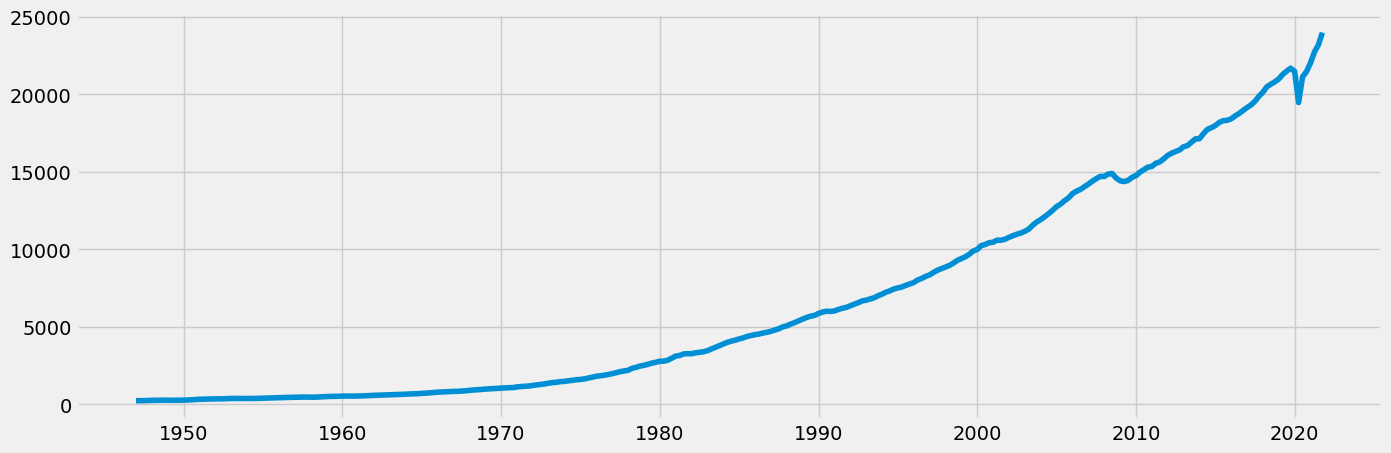

In [8]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(data)

### 2. Subsetting, wrangling, and cleaning time-series data

In [9]:
# Reset index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [10]:
data_2.head()

,Date,Value
0,1947-01-01,243.164
1,1947-04-01,245.968
2,1947-07-01,249.585
3,1947-10-01,259.745
4,1948-01-01,265.742


### Filter all data from 1996 to present

In [11]:
data_sub = data_2.loc[(data_2['Date'] >= '1996-01-01') & (data_2['Date'] < '2024-01-01')]

In [12]:
data_sub.shape

(104, 2)

In [13]:
data_sub.head()

,Date,Value
196,1996-01-01,7868.468
197,1996-04-01,8032.840
198,1996-07-01,8131.408
199,1996-10-01,8259.771
200,1997-01-01,8362.655


In [14]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
1996-01-01,7868.468
1996-04-01,8032.840
1996-07-01,8131.408
1996-10-01,8259.771
1997-01-01,8362.655


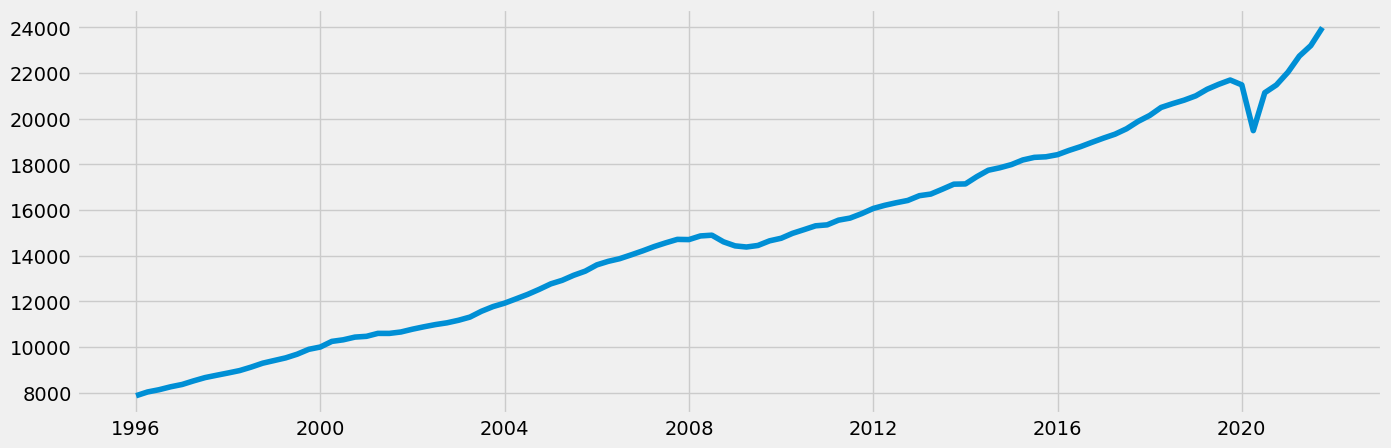

In [15]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [16]:
# Check for missing values (you shouldn't have any)

data_sub.isnull().sum() 

Value    0
dtype: int64

In [17]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()

# No dups!

0

### 3. Time-series analysis: decomposition

In [18]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [19]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

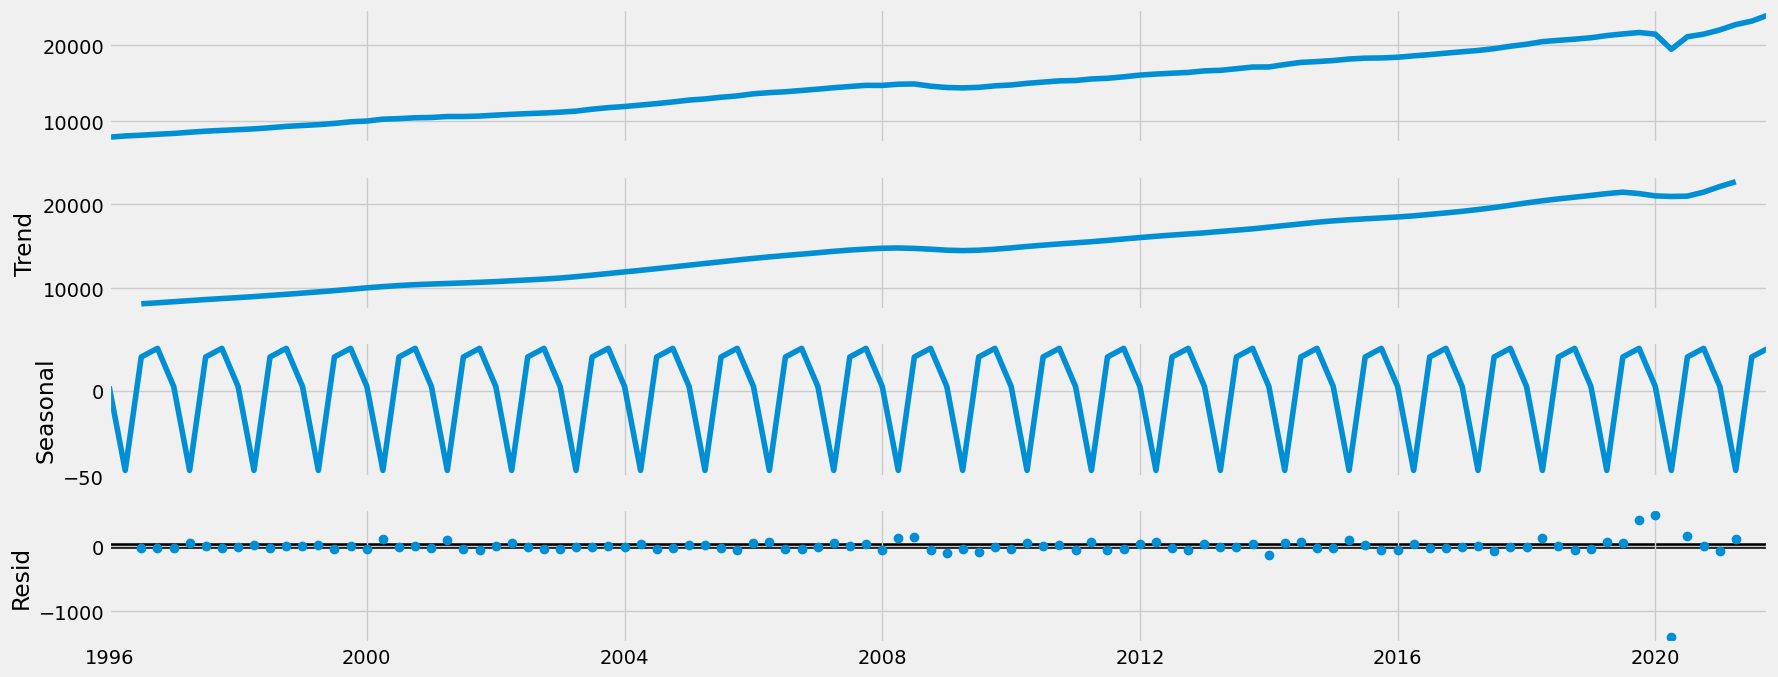

In [20]:
# Plot the separate components

decomposition.plot()
plt.show()

### There is an increasing trend, with an element of seasonality. The seasonality indicates an annual pattern.

### Noise is low, except in 2020, where there is a visible dip in the GDP. This is likely due to the effects of the global pandemic's on GDP.

### 4. Testing for stationarity

In [21]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Test Statistic                   1.348690
p-value                          0.996868
Number of Lags Used              1.000000
Number of Observations Used    102.000000
Critical Value (1%)             -3.496149
Critical Value (5%)             -2.890321
Critical Value (10%)            -2.582122
dtype: float64


### The test statistic (1.3) is much larger than the 5% critical value (-2.9). Therefore the data needs to be stationarised.

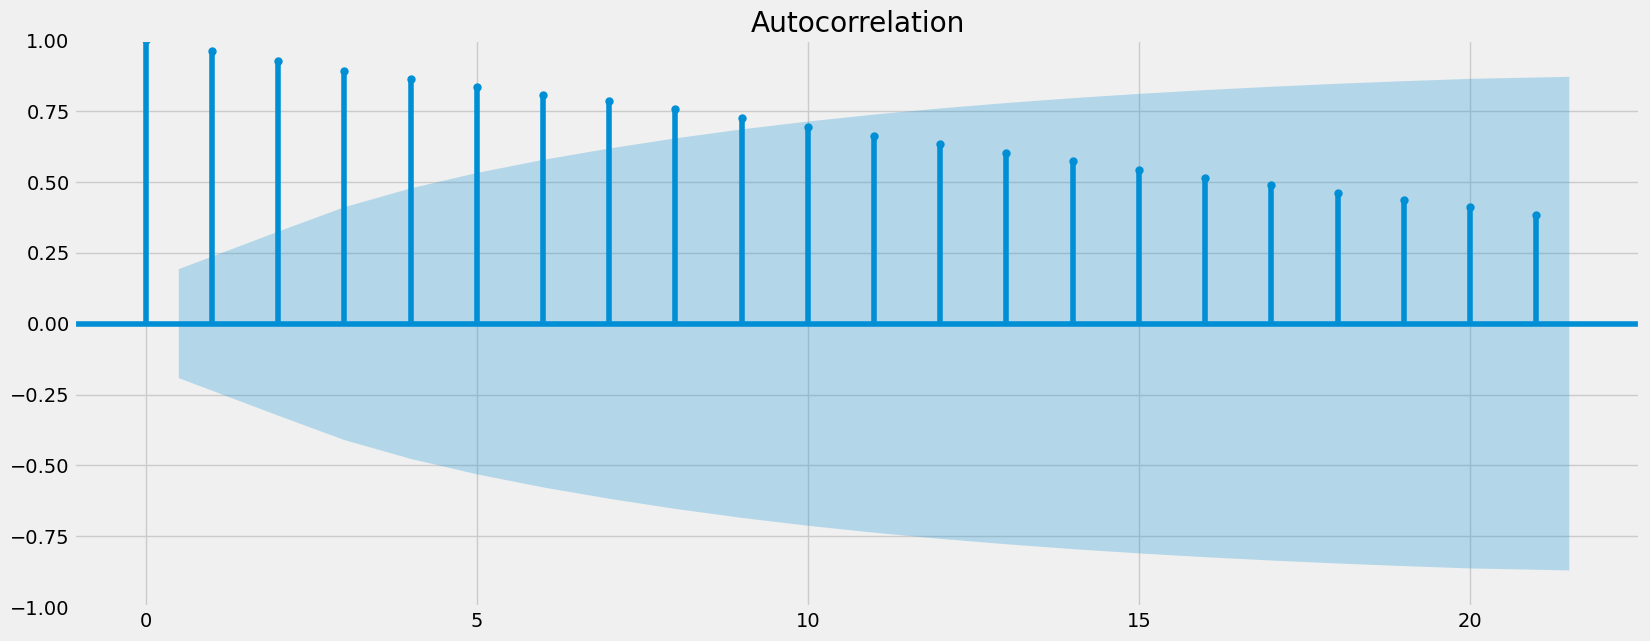

In [22]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

### The are significant points of lag (9), also indicating the need for stationarisation.

### 5. Stationarizing the Federal Reserve Economic Data

In [23]:
data_diff = data_sub - data_sub.shift(1)
# The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [24]:
data_diff.dropna(inplace = True)
# Remove the missing values that came about as a result of the differencing.

In [25]:
data_diff.head()

,Value
datetime,
1996-04-01,164.372
1996-07-01,98.568
1996-10-01,128.363
1997-01-01,102.884
1997-04-01,156.170


In [26]:
data_diff.columns

Index(['Value'], dtype='object')

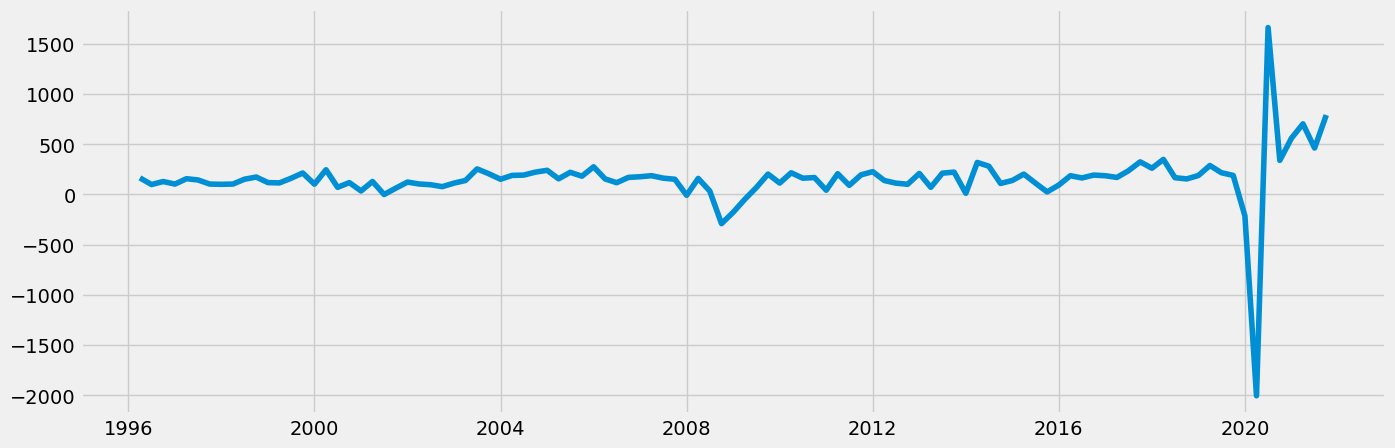

In [27]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

### The plot no longer shows an increasing value, it appears to be closer to stationary data.
### The stationary tests will be rerun

In [28]:
pd.options.display.float_format = '{:2f}'.format

In [29]:
dickey_fuller(data_diff)

Test Statistic                -11.193439
p-value                         0.000000
Number of Lags Used             0.000000
Number of Observations Used   102.000000
Critical Value (1%)            -3.496149
Critical Value (5%)            -2.890321
Critical Value (10%)           -2.582122
dtype: float64


The critical value is -11.19, which is lower than the critial value (-2.89).
The p-value is  <0.05

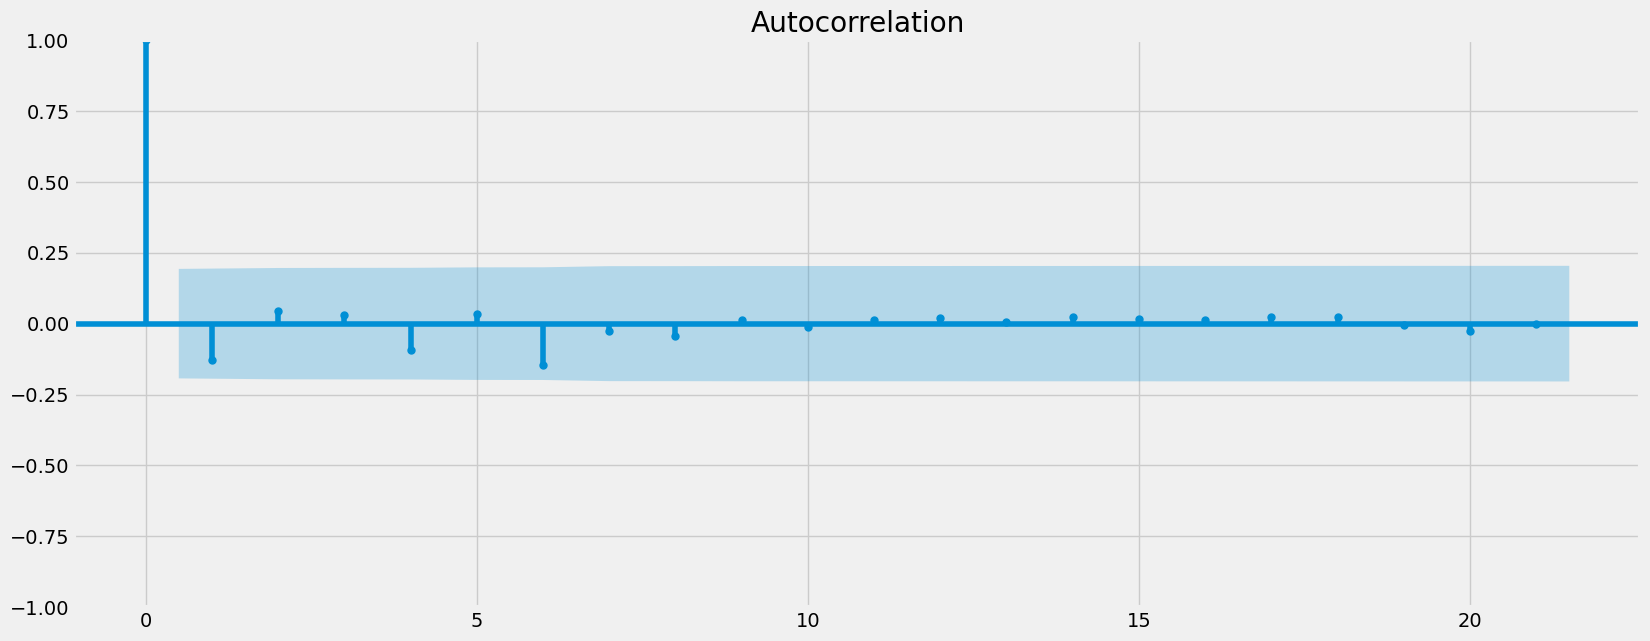

In [30]:
plot_acf(data_diff)
plt.show()

### The lags are now all inside the confidance interval.
### Therefore, the data has be stationarised.

# BONUS TASK

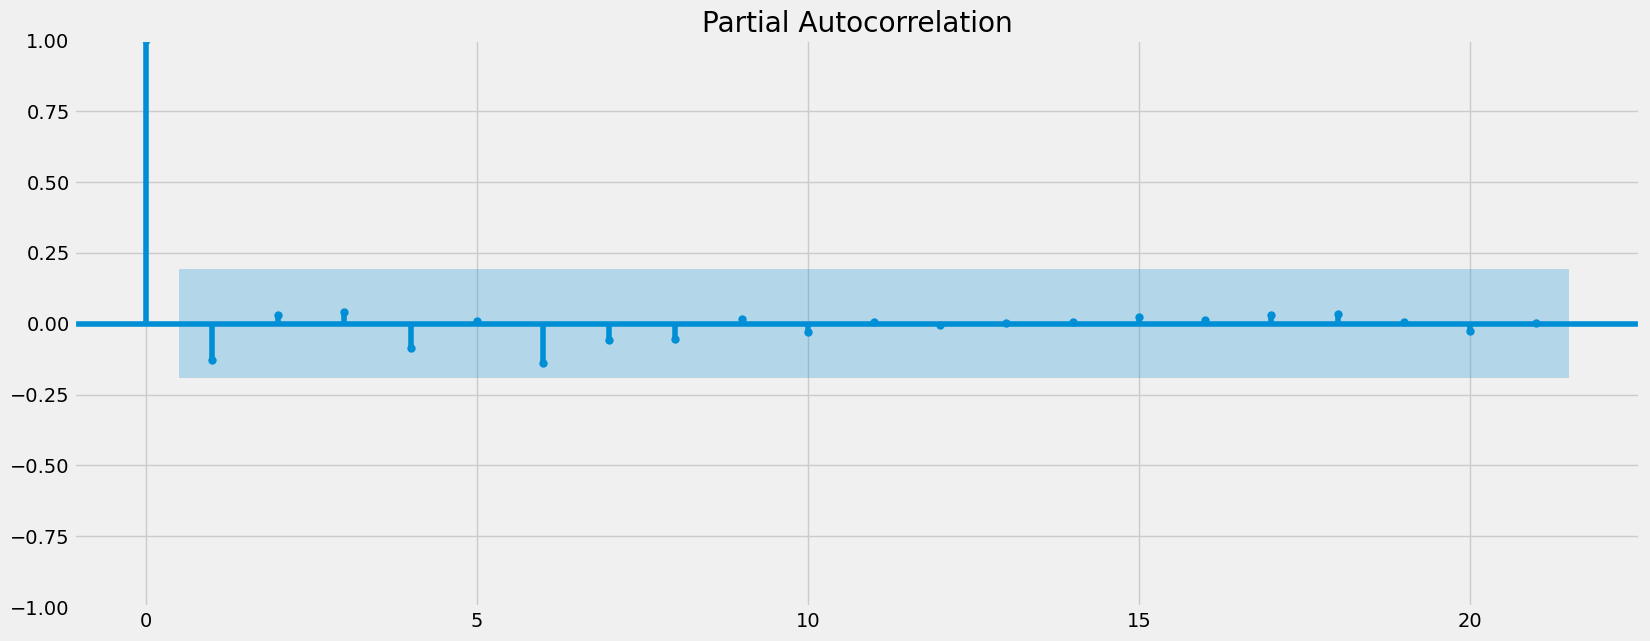

<Figure size 4500x4500 with 0 Axes>

In [31]:
# Plot partial autocorrelations to determine parameter p

plot_pacf(data_diff)
plt.figure(figsize=(15,15), dpi=300)
plt.show()

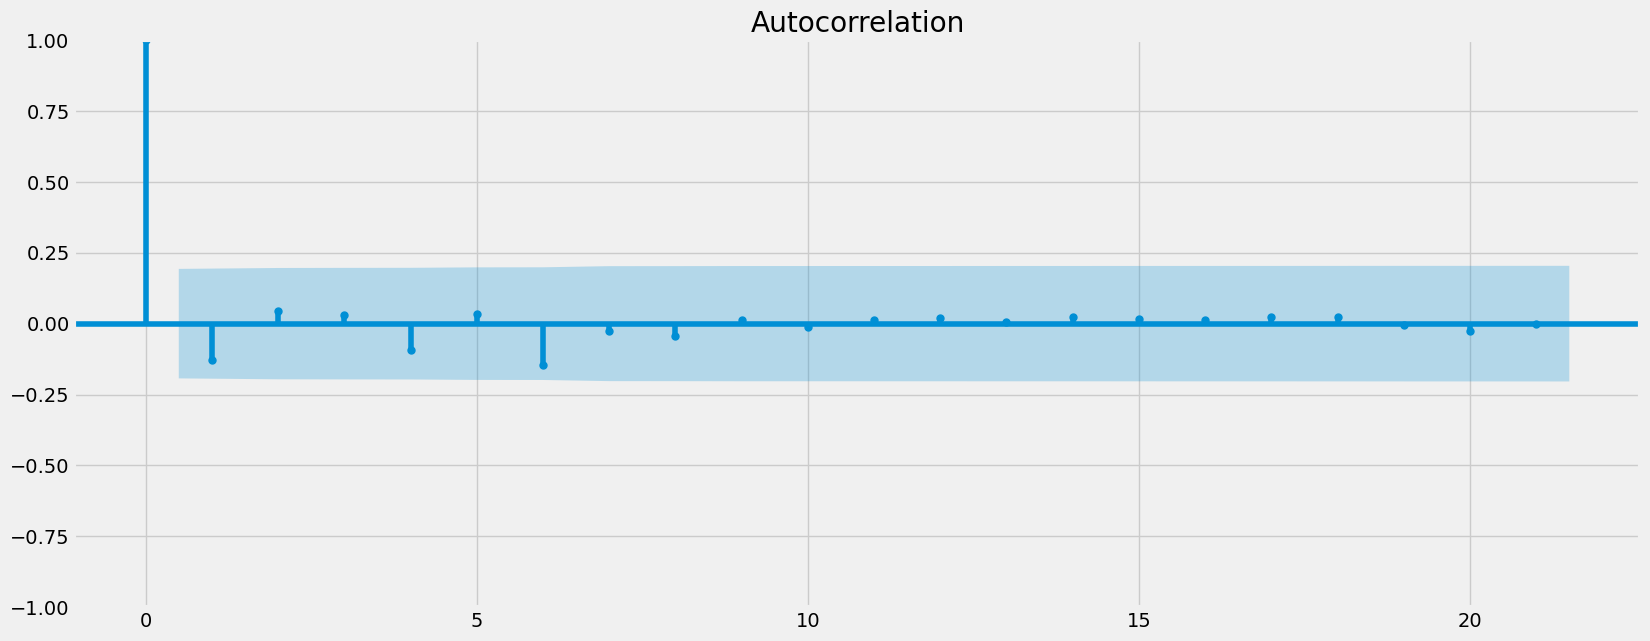

<Figure size 1500x500 with 0 Axes>

In [32]:
# Plot autocorrelations to determine parameter q

plot_acf(data_diff)
plt.figure(figsize=(15,5), dpi=100)
plt.show()